# Import

In [ ]:
# https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [ ]:
import pandas as pd
from google.colab import drive
import torch
import numpy as np

!pip install nlpaug
import nlpaug.augmenter.word as naw

!pip install transformers
from transformers import BertTokenizer

import nltk
nltk.download('punkt')

from torch import nn
from transformers import BertModel

from torch.optim import Adam
from tqdm import tqdm

import matplotlib.pyplot as plt

drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preproccessing

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/nlp/data.csv')
df.head()

,Text,Classification,Sentiment
0,ریدم پس‌ِ کله‌ی خدائی که اینهمه وقت نخواسته سخ...,WithoutContent,None
1,در زدن خانم همسایه‌پایینی بود. تا گفتم سلام صو...,WithoutContent,None
2,فضای مجازی ویترینه . حریم خصوصی نیست. حوزه نما...,WithoutContent,None
3,بعد به مصرف‌کننده خونگی می‌گن کمتر حموم برو و ...,WithoutContent,None
4,این قراضه سنش دو برابر من بود، آه و واویلا دار...,WithoutContent,None


In [ ]:
df.describe()

,Text,Classification,Sentiment
count,4999,4999,4998
unique,4999,3,4
top,ریدم پس‌ِ کله‌ی خدائی که اینهمه وقت نخواسته سخ...,WithoutContent,None
freq,1,3832,3853


In [ ]:
df.isna().sum()

Text              0
Classification    0
Sentiment         1
dtype: int64

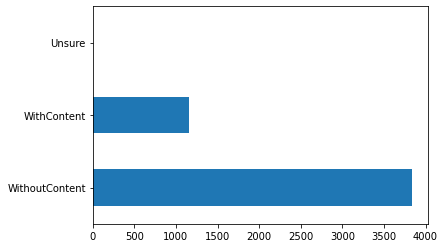

In [ ]:
df['Classification'].value_counts().plot(kind='barh')

In [ ]:
df['Classification'].value_counts()

WithoutContent    3832
WithContent       1158
Unsure               9
Name: Classification, dtype: int64

In [ ]:
WithContent = df[df['Classification'] == 'WithContent']
WithContent.shape

(1158, 3)

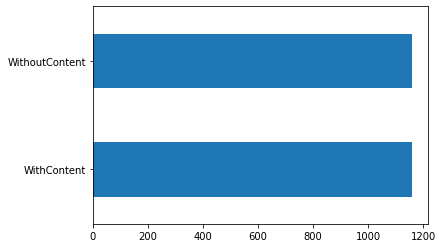

In [ ]:
data_Classification = WithContent.append(df[df['Classification'] == 'WithContent'].sample(WithContent.shape[0]), ignore_index=True)
data_Classification = WithContent.append(df[df['Classification'] == 'WithoutContent'].sample(WithContent.shape[0]), ignore_index=True)
data_Classification['Classification'].value_counts().plot(kind='barh')

In [ ]:
def delete_Stopword(txt):
    file = nltk.word_tokenize(txt)
    newFile=''
    stopWord=[]
    fin=open('/content/drive/MyDrive/nlp/stopword.txt',encoding='utf8')

    for word in fin.readlines():
        stopWord.append(word.replace('\n', '').lower().replace('\ufeff', '').lower().replace('\ufeff', '').upper().replace('ك' , 'ک').replace(" " ,""))



    for word in file:
        word=word.replace(' ', '')
        if word in stopWord:
            continue
        else:
            newFile = newFile + ' ' + word


    return newFile

In [ ]:
def normalizer(txt):
    file = nltk.word_tokenize(txt)
    newfile=''
    for word in file:
        word = word.replace(" ", "").replace("\u200c", "").replace(".", ". ").upper().replace("\ufeff\n","").lower().replace(
            "،", "، ").upper().replace('ة' , 'ه').replace('ي', 'ی').replace("؛" , '؛ ').upper().replace("؛" , ' ؛').lower().replace("." , ' .').lower().replace(
            "،", " ،").lower().replace('\xa0','').replace('ک' , 'ك').replace('پ' , 'ب').replace('گ' ,'ك' )
        newfile = newfile + ' ' + word

    return newfile

In [ ]:
for i in range(len(data_Classification)):
  delete_Stopword(data_Classification['Text'][i])
  normalizer(data_Classification['Text'][i])
  data_Classification['Text'][i].split()
  " ".join(data_Classification['Text'][i])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = normalizer('علی')
bert_input = tokenizer(example_text,padding='max_length', max_length = 2, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

We need to remove 3 to truncate the input but the first sequence has a length 3. 


tensor([[  101,   583, 28495, 28506,   102]])
tensor([[0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1]])


In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(normalizer(example_text))

 [ cls ] علی [ sep ]


# Data Augment

In [ ]:
#https://towardsdatascience.com/text-augmentation-in-few-lines-of-python-code-cdd10cf3cf84
#https://nlpaug.readthedocs.io/en/latest/augmenter/word/antonym.html
aug = naw.RandomWordAug()

new_data=pd.DataFrame()
for i in range(len(data_Classification)):
  aug_text=aug.augment(data_Classification.iloc[i,0],n=3, num_thread=5)
  for txt in aug_text:
    df2=[[aug_text[0],data_Classification.iloc[i,1],data_Classification.iloc[i,2]]]
    new_data=new_data.append(df2,ignore_index=True)

print(new_data.shape,data_Classification.shape)

columns =list(data_Classification.columns)
data_Classification=new_data
data_Classification.columns = columns

(6948, 3) (2316, 3)


In [ ]:
data_Classification['Classification'].value_counts()

WithContent       3474
WithoutContent    3474
Name: Classification, dtype: int64

# Custom Dataset

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'WithoutContent':0,
          'WithContent':1
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Classification']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(data_Classification.iloc[:,:2].sample(frac=1, random_state=42), 
                                     [int(.7*len(data_Classification)), int(.9*len(data_Classification))])

print(len(df_train),len(df_val), len(df_test))

4863 1390 695


# Custom Model

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

# Train & evaluate functions

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):
    train_loss=[]
    val_loss=[]
    train_acc=[]
    val_acc=[]

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)


    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if torch.cuda.is_available():

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            
            train_loss.append(total_loss_train / len(train_data))
            val_loss.append(total_loss_val / len(val_data))
            train_acc.append(total_acc_train / len(train_data))
            val_acc.append(total_acc_val / len(val_data))
            
    return train_loss,val_loss,train_acc,val_acc

            

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

# Train and Plot

In [ ]:
EPOCHS = 10
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_loss,val_loss,train_acc,val_acc=train(model, df_train, df_val, LR, EPOCHS)
torch.save(model, '/content/drive/MyDrive/nlp/model_data_Classification_yes_aug/model_data_Classification_yes_aug.pt')

100%|██████████| 2432/2432 [08:42<00:00,  4.65it/s]


Epochs: 1 | Train Loss:  0.314                 | Train Accuracy:  0.653                 | Val Loss:  0.283                 | Val Accuracy:  0.729


100%|██████████| 2432/2432 [08:43<00:00,  4.65it/s]


Epochs: 2 | Train Loss:  0.249                 | Train Accuracy:  0.776                 | Val Loss:  0.234                 | Val Accuracy:  0.791


100%|██████████| 2432/2432 [08:43<00:00,  4.65it/s]


Epochs: 3 | Train Loss:  0.177                 | Train Accuracy:  0.873                 | Val Loss:  0.217                 | Val Accuracy:  0.828


100%|██████████| 2432/2432 [08:43<00:00,  4.65it/s]


Epochs: 4 | Train Loss:  0.105                 | Train Accuracy:  0.939                 | Val Loss:  0.172                 | Val Accuracy:  0.888


100%|██████████| 2432/2432 [08:43<00:00,  4.64it/s]


Epochs: 5 | Train Loss:  0.069                 | Train Accuracy:  0.966                 | Val Loss:  0.149                 | Val Accuracy:  0.912


100%|██████████| 2432/2432 [08:42<00:00,  4.65it/s]


Epochs: 6 | Train Loss:  0.048                 | Train Accuracy:  0.976                 | Val Loss:  0.124                 | Val Accuracy:  0.933


100%|██████████| 2432/2432 [08:43<00:00,  4.65it/s]


Epochs: 7 | Train Loss:  0.034                 | Train Accuracy:  0.983                 | Val Loss:  0.111                 | Val Accuracy:  0.934


100%|██████████| 2432/2432 [08:42<00:00,  4.65it/s]


Epochs: 8 | Train Loss:  0.035                 | Train Accuracy:  0.980                 | Val Loss:  0.107                 | Val Accuracy:  0.938


100%|██████████| 2432/2432 [08:42<00:00,  4.66it/s]


Epochs: 9 | Train Loss:  0.022                 | Train Accuracy:  0.986                 | Val Loss:  0.109                 | Val Accuracy:  0.935


100%|██████████| 2432/2432 [08:43<00:00,  4.65it/s]


Epochs: 10 | Train Loss:  0.027                 | Train Accuracy:  0.980                 | Val Loss:  0.106                 | Val Accuracy:  0.942


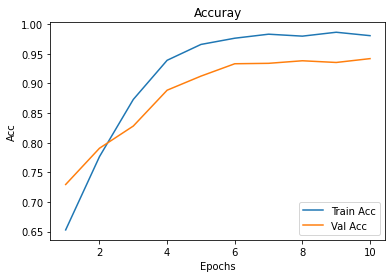

In [ ]:
fig = plt.figure()

plt.subplot(111)

plt.plot(np.arange(1,EPOCHS+1),train_acc)

plt.plot(np.arange(1,EPOCHS+1),val_acc)

plt.title("Accuray")

plt.xlabel("Epochs")

plt.ylabel("Acc")

plt.legend(["Train Acc","Val Acc"],loc = "lower right")

plt.savefig("/content/drive/MyDrive/nlp/model_data_Classification_yes_aug/model_data_Classification_yes_aug_Acc.png",dpi = 600)

plt.show()

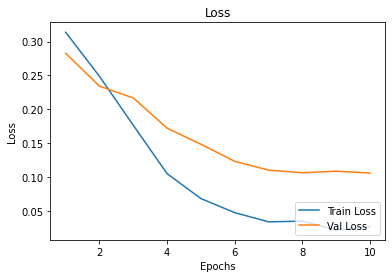

In [ ]:
fig = plt.figure()

plt.subplot(111)

plt.plot(np.arange(1,EPOCHS+1),train_loss)

plt.plot(np.arange(1,EPOCHS+1),val_loss)

plt.title("Loss")

plt.xlabel("Epochs")

plt.ylabel("Loss")

plt.legend(["Train Loss","Val Loss"],loc = "lower right")

plt.savefig("/content/drive/MyDrive/nlp/model_data_Classification_yes_aug/model_data_Classification_yes_aug_Loss.png",dpi = 600)

plt.show()

In [ ]:
model = torch.load('/content/drive/MyDrive/nlp/model_data_Classification_yes_aug/model_data_Classification_yes_aug.pt')

In [ ]:
evaluate(model, df_test)

Test Accuracy:  0.948


In [ ]:
my_text='''
پیش‌بینی آب و هوای امروز پنجشنبه ۷ فروردین وضعیت آب و هوا در ۲۴ ساعت گذشته، شرایط آب و هوای امروز و پیش‌بینی آب و هوای سه روز آینده'''
aug = naw.RandomWordAug()
aug.augment(my_text,n=3, num_thread=3)

['\u200c آب و امروز ۷ فروردین وضعیت آب و هوا در ساعت ، شرایط آب و امروز پیش \u200c بینی و هوای سه روز',
 'پیش \u200c آب و امروز پنجشنبه ۷ فروردین وضعیت آب هوا در ساعت گذشته ، آب و هوای امروز \u200c بینی آب سه آینده',
 'پیش \u200c بینی آب امروز ۷ وضعیت و هوا ۲۴ ساعت ، و هوای امروز و پیش \u200c بینی آب و هوای سه آینده']